In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import credentials to access kaggle
import os
os.environ['KAGGLE_USERNAME']="omirosboutsios"
os.environ['KAGGLE_KEY']="8ef56abccae1864bc255cee2fcdf436d"

In [ ]:
# Download data from kaggle
!kaggle competitions download -c detect-pneumonia-spring-2023

100% 1.13G/1.14G [00:12<00:00, 148MB/s]
100% 1.14G/1.14G [00:12<00:00, 101MB/s]


In [ ]:
# Unzip data
!unzip detect-pneumonia-spring-2023.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/test_images/img_7169925662333297601.jpg  
  inflating: test_images/test_images/img_7173963727515602195.jpg  
  inflating: test_images/test_images/img_7190629333810912094.jpg  
  inflating: test_images/test_images/img_7201843388805359804.jpg  
  inflating: test_images/test_images/img_7207120539432869321.jpg  
  inflating: test_images/test_images/img_7220060562137170030.jpg  
  inflating: test_images/test_images/img_7227354360494212144.jpg  
  inflating: test_images/test_images/img_7230829381665638374.jpg  
  inflating: test_images/test_images/img_7231127042848917754.jpg  
  inflating: test_images/test_images/img_7241224584347820565.jpg  
  inflating: test_images/test_images/img_7250572414191838877.jpg  
  inflating: test_images/test_images/img_7257483060246601206.jpg  
  inflating: test_images/test_images/img_7263989080063621968.jpg  
  inflating: test_images/test_images/img_7268272383967734935.jpg  
  inflating

In [ ]:
# Import libraries
import cv2
import pandas as pd
import os
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
# Assign directories for train and test data
train_dir = "/content/train_images/train_images"
test_dir = "/content/test_images/test_images"

In [ ]:
# Read csv file with labels of train data
train_labels = pd.read_csv('labels_train.csv')

In [ ]:
# Import training data and pre-process images
SIZE=224
X_dataset=[]
for i in range(train_labels.shape[0]):
    img_path = os.path.join(train_dir, train_labels['file_name'][i])
    img = image.load_img(img_path, target_size=(SIZE, SIZE))
    img = image.img_to_array(img)
    img = img / 255.0
    X_dataset.append(img)

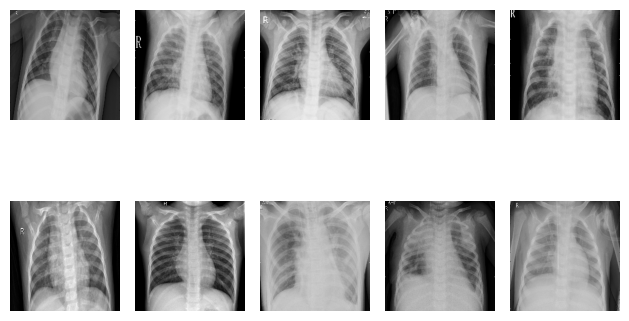

In [ ]:
# Plot 10 images for visualization
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_dataset[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Make numpy array the training images and change training labels to categorical
X=np.array(X_dataset)
train_labels_categorical = to_categorical(train_labels["class_id"], num_classes=3)

In [ ]:
# Split the training data to train and validation
train_images, val_images, train_labels, val_labels = train_test_split(X, train_labels_categorical, test_size=0.2, random_state=42)

In [ ]:
# Simple data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Augment only 16 images
augmented_images = datagen.flow(train_images, train_labels, batch_size=16)

In [ ]:
# Concatenate original images with augmented images
combined_X = np.concatenate([train_images, augmented_images[0][0]], axis=0)
combined_y = np.concatenate([train_labels, augmented_images[0][1]], axis=0)

In [ ]:
# Create checkpoint to save the best model with highest accuracy
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='vgg19pre-train.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
# Create model and fine tune it, freeze all layers of original VGG19 model
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x= vgg.output
x= Flatten()(x)
x = Dense(4096, activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.7)(x)
x= Dense(4096,activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.7)(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Compile the model
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Fit the model
history = model.fit(combined_X, combined_y, batch_size=64, epochs=50, validation_data=(val_images, val_labels),verbose=1,callbacks=[checkpoint])

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 1.5766 - accuracy: 0.5566
Epoch 1: val_accuracy improved from -inf to 0.69519, saving model to vgg19pre-train.h5
59/59 [==============================] - 19s 139ms/step - loss: 1.5766 - accuracy: 0.5566 - val_loss: 0.7380 - val_accuracy: 0.6952
Epoch 2/50
58/59 [============================>.] - ETA: 0s - loss: 1.1480 - accuracy: 0.6740
Epoch 2: val_accuracy improved from 0.69519 to 0.75187, saving model to vgg19pre-train.h5
59/59 [==============================] - 6s 100ms/step - loss: 1.1466 - accuracy: 0.6747 - val_loss: 0.6421 - val_accuracy: 0.7519
Epoch 3/50
58/59 [============================>.] - ETA: 0s - loss: 1.0414 - accuracy: 0.7091
Epoch 3: val_accuracy improved from 0.75187 to 0.76257, saving model to vgg19pre-train.h5
59/59 [==============================] - 6s 97ms/step - loss: 1.0349 - accuracy: 0.7106 - val_loss: 0.6007 - val_accuracy: 0.7626
Epoch 4/50
58/59 [============================>.] - ETA: 0

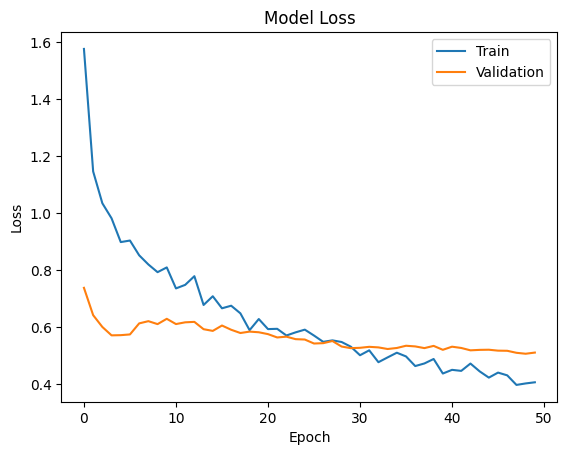

In [ ]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

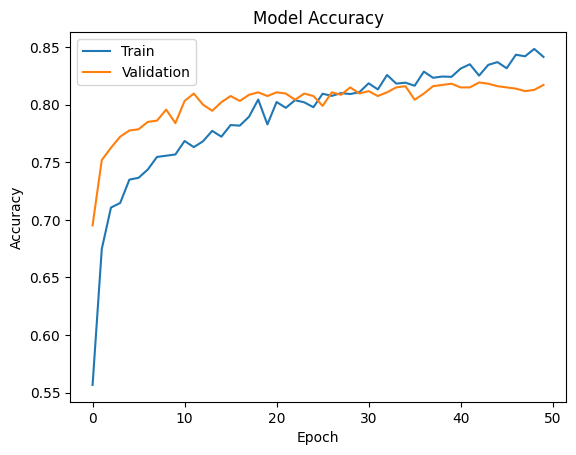

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Retrieve the predicted labels for the training data
predicted_labels = np.argmax(model.predict(combined_X), axis=1)

# Retrieve the true labels for the training data
true_labels = np.argmax(combined_y, axis=1)

# Find the misclassified instances
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Retrieve the misclassified predicted labels
misclassified_predicted_labels = predicted_labels[misclassified_indices]

# Retrieve the corresponding true labels
misclassified_true_labels = true_labels[misclassified_indices]

# Count the number of misclassifications
num_misclassifications = len(misclassified_indices)

# Print the count of misclassifications
print("Number of Misclassifications:", num_misclassifications)

# Define a list of class labels
class_labels = ['Class 0', 'Class 1', 'Class 2']

# Print the misclassified instances and their labels
print("Misclassified Instances:")
for i in range(len(misclassified_indices)):
    instance_index = misclassified_indices[i]
    true_label = class_labels[misclassified_true_labels[i]]
    predicted_label = class_labels[misclassified_predicted_labels[i]]
    print("Instance", instance_index, "- True Label:", true_label, "Predicted Label:", predicted_label)

118/118 [==============================] - 3s 25ms/step
Number of Misclassifications: 281
Misclassified Instances:
Instance 36 - True Label: Class 1 Predicted Label: Class 2
Instance 46 - True Label: Class 2 Predicted Label: Class 1
Instance 64 - True Label: Class 1 Predicted Label: Class 2
Instance 78 - True Label: Class 2 Predicted Label: Class 0
Instance 79 - True Label: Class 2 Predicted Label: Class 1
Instance 101 - True Label: Class 1 Predicted Label: Class 2
Instance 106 - True Label: Class 0 Predicted Label: Class 2
Instance 114 - True Label: Class 2 Predicted Label: Class 1
Instance 128 - True Label: Class 2 Predicted Label: Class 1
Instance 133 - True Label: Class 2 Predicted Label: Class 1
Instance 135 - True Label: Class 2 Predicted Label: Class 1
Instance 138 - True Label: Class 2 Predicted Label: Class 1
Instance 180 - True Label: Class 2 Predicted Label: Class 1
Instance 215 - True Label: Class 1 Predicted Label: Class 2
Instance 221 - True Label: Class 2 Predicted Label

In [ ]:
# Print all VGG19 layers
for i, layer in enumerate(vgg.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [ ]:
# Unfreeze only the last 10 layers and keep freeze the first 12 layers
for layer in model.layers[:12]:
    layer.trainable = False
for layer in model.layers[12:]:
    layer.trainable = True

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [ ]:
# Create second checkpoint to save the best model with highest accuracy
checkpoint = ModelCheckpoint(
    filepath='vgg19after-train.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
# Fit the model
history = model.fit(combined_X, combined_y, batch_size=64, epochs=50, validation_data=(val_images, val_labels),verbose=1,callbacks=[checkpoint])

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8241
Epoch 1: val_accuracy improved from -inf to 0.80321, saving model to vgg19after-train.h5
59/59 [==============================] - 11s 134ms/step - loss: 0.4459 - accuracy: 0.8241 - val_loss: 0.5654 - val_accuracy: 0.8032
Epoch 2/50
58/59 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.8200
Epoch 2: val_accuracy did not improve from 0.80321
59/59 [==============================] - 5s 79ms/step - loss: 0.4752 - accuracy: 0.8201 - val_loss: 0.7036 - val_accuracy: 0.7647
Epoch 3/50
58/59 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.8198
Epoch 3: val_accuracy improved from 0.80321 to 0.80963, saving model to vgg19after-train.h5
59/59 [==============================] - 6s 108ms/step - loss: 0.4536 - accuracy: 0.8193 - val_loss: 0.5661 - val_accuracy: 0.8096
Epoch 4/50
58/59 [============================>.] - ETA: 0s - loss: 0.4461 - accuracy: 0.8276

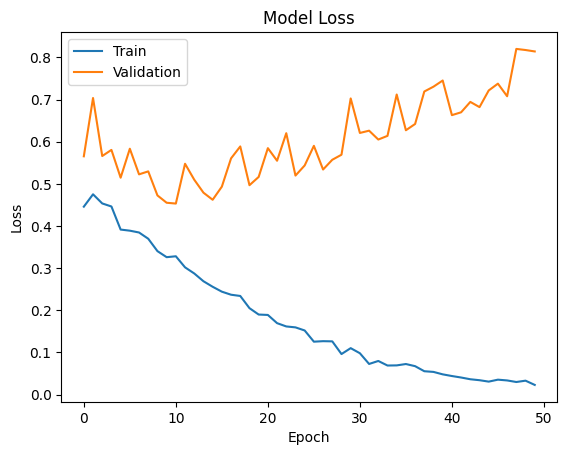

In [ ]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

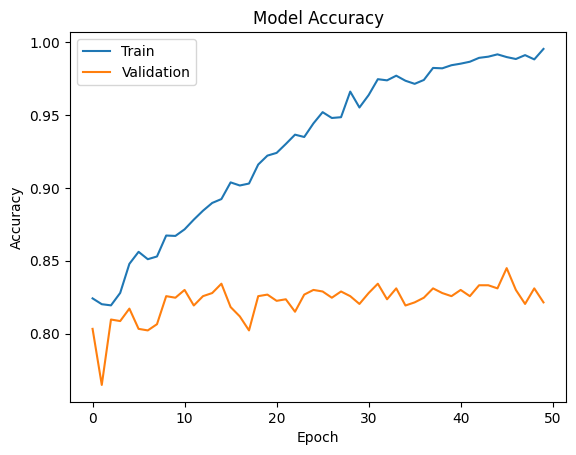

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Load the model to make a prediction in unseen data
model = load_model('/content/vgg19pre-train.h5')

# Define the image dimensions
img_width, img_height = 224, 224

# DataFrame to store results
results = []

# Loop over each file in the test directory
for file in os.listdir(test_dir):
    # Load the image file
    img_path = os.path.join(test_dir, file)
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_width, img_height), Image.NEAREST)  # Resize the image

    # Convert the image to a numpy array and reshape it
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Normalize the image
    x /= 255.0

    # Use the model to make a prediction
    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    # Add the filename and prediction to the results
    results.append({'file_name': file, 'class_id': predicted_class})

# Convert results to a DataFrame and save as a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('test_vgg19.csv', index=False)

1/1 [==============================] - 0s 25ms/step


# Second model

In [ ]:
IMAGE_SIZE = [224, 224]
res = ResNet101(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in res.layers:
  layer.trainable = False
x= res.output
x = GlobalAveragePooling2D()(x)
x= Dense(128,activation='relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.7)(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=res.input, outputs=prediction)
model.summary()

171446536/171446536 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# Compile the model
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Create checkpoint to save the best model with highest accuracy
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='respre-train.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
# Fit the model
history = model.fit(combined_X, combined_y, batch_size=64, epochs=50, validation_data=(val_images, val_labels),verbose=1,callbacks=[checkpoint])

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 1.1434 - accuracy: 0.4951
Epoch 1: val_accuracy improved from -inf to 0.27594, saving model to respre-train.h5
59/59 [==============================] - 22s 130ms/step - loss: 1.1434 - accuracy: 0.4951 - val_loss: 1.4556 - val_accuracy: 0.2759
Epoch 2/50
58/59 [============================>.] - ETA: 0s - loss: 1.0226 - accuracy: 0.5547
Epoch 2: val_accuracy did not improve from 0.27594
59/59 [==============================] - 3s 58ms/step - loss: 1.0222 - accuracy: 0.5542 - val_loss: 1.3235 - val_accuracy: 0.2759
Epoch 3/50
58/59 [============================>.] - ETA: 0s - loss: 0.9546 - accuracy: 0.5964
Epoch 3: val_accuracy improved from 0.27594 to 0.28449, saving model to respre-train.h5
59/59 [==============================] - 4s 73ms/step - loss: 0.9530 - accuracy: 0.5971 - val_loss: 1.2565 - val_accuracy: 0.2845
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.6144
Epoch 4:

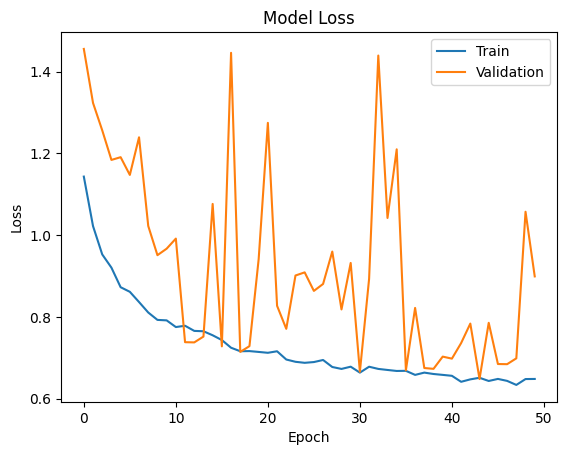

In [ ]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

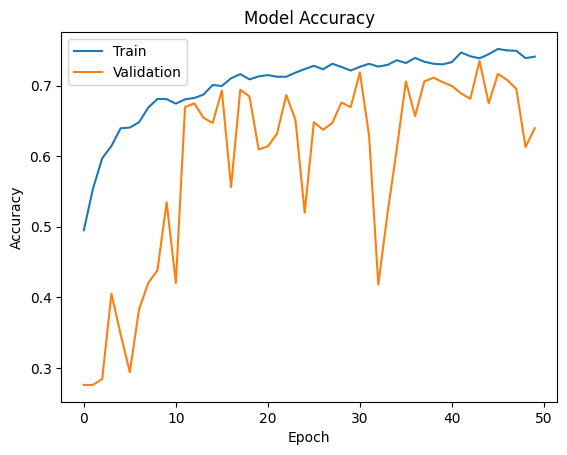

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Retrieve the predicted labels for the training data
predicted_labels = np.argmax(model.predict(combined_X), axis=1)

# Retrieve the true labels for the training data
true_labels = np.argmax(combined_y, axis=1)

# Find the misclassified instances
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Retrieve the misclassified predicted labels
misclassified_predicted_labels = predicted_labels[misclassified_indices]

# Retrieve the corresponding true labels
misclassified_true_labels = true_labels[misclassified_indices]

# Count the number of misclassifications
num_misclassifications = len(misclassified_indices)

# Print the count of misclassifications
print("Number of Misclassifications:", num_misclassifications)

# Define a list of class labels
class_labels = ['Class 0', 'Class 1', 'Class 2']

# Print the misclassified instances and their labels
print("Misclassified Instances:")
for i in range(len(misclassified_indices)):
    instance_index = misclassified_indices[i]
    true_label = class_labels[misclassified_true_labels[i]]
    predicted_label = class_labels[misclassified_predicted_labels[i]]
    print("Instance", instance_index, "- True Label:", true_label, "Predicted Label:", predicted_label)

118/118 [==============================] - 5s 26ms/step
Number of Misclassifications: 1287
Misclassified Instances:
Instance 2 - True Label: Class 2 Predicted Label: Class 1
Instance 6 - True Label: Class 2 Predicted Label: Class 1
Instance 10 - True Label: Class 0 Predicted Label: Class 1
Instance 11 - True Label: Class 2 Predicted Label: Class 0
Instance 12 - True Label: Class 2 Predicted Label: Class 1
Instance 13 - True Label: Class 2 Predicted Label: Class 1
Instance 19 - True Label: Class 2 Predicted Label: Class 1
Instance 20 - True Label: Class 2 Predicted Label: Class 1
Instance 25 - True Label: Class 2 Predicted Label: Class 1
Instance 29 - True Label: Class 2 Predicted Label: Class 1
Instance 30 - True Label: Class 2 Predicted Label: Class 1
Instance 31 - True Label: Class 2 Predicted Label: Class 1
Instance 32 - True Label: Class 2 Predicted Label: Class 1
Instance 35 - True Label: Class 2 Predicted Label: Class 1
Instance 40 - True Label: Class 2 Predicted Label: Class 1
I

# Conclusions

Please note that this notebook presents a limited selection of the models and architectures I experimented with to tackle the challenge of multiclass X-ray classification. Throughout my project, I explored various other models and architectures beyond those shown here in an attempt to improve the classification performance. However, due to the limitations of space and time, this notebook focuses on presenting two representative models: the VGG19 model and the ResNet50. Rest assured that the exploration of alternative models and architectures was an extensive and comprehensive process, aimed at finding the most effective approach for this complex classification task.

During my Kaggle competition project on multiclass X-ray classification, I encountered a slightly unbalanced dataset. The training set consisted of 1227 images belonging to class 0 (normal), 2239 images belonging to class 1 (bacterial pneumonia), and 1207 images belonging to class 2 (viral pneumonia). I initially attempted to address the data imbalance by experimenting with various techniques.

One of the major challenges I faced was the difficulty in distinguishing between class 1  and class 2. Initially, with the slightly unbalanced dataset, my model struggled with these two classes. However, to address this issue, I attempted to balance the dataset by including an equal number of images from each class. Surprisingly, this approach resulted in even worse accuracy. Despite having a balanced dataset with an equal number of images from each class, the model still struggled to discern the subtle differences between the two pneumonia types.

In an effort to improve the model's performance, I explored different data augmentation techniques. I applied these techniques to class 1 only, class 2 only, both classes simultaneously and all 3 classes. Unfortunately, none of these data augmentation approaches yielded significant improvements. The model continued to struggle with accurately distinguishing between bacterial pneumonia and viral pneumonia, despite the variations introduced through data augmentation.

Therefore, it became evident that the challenge of distinguishing between these 2 classes extended beyond the data distribution imbalance. The subtle differences between the pneumonia types presented a complex classification problem that was not easily addressed through traditional data augmentation techniques alone.

Among the pre-trained models available in the Keras library, I conducted a couple of random searches to explore other options. However, I found that these alternative pre-trained models did not perform as well as the VGG19 model for my specific X-ray classification problem. Initially, when I froze all the layers from the VGG19 pre-trained model, I observed minimal overfitting. However, upon unfreezing the last 10 layers, I noticed an increase in overfitting. Despite this overfitting, the model exhibited better validation accuracy and performed well on unseen data.

In addition to my efforts, I also explored ensemble methods using different VGG19 architectures and other models in an attempt to improve the results. I experimented with ensemble techniques such as majority voting, averaging, and maximum voting. However, despite these attempts,  I still did not achieve satisfactory results in terms of the public score. Although, when analyzing the private score, i observed more promising outcomes. These results provided a better indication of the model's performance and suggested that the ensemble methods employed did indeed have a positive impact. Despite the initial setback with the public score, the private score indicated that the ensemble techniques were effective in improving the overall performance of the models.

Additionally, I explored the creation of an ensemble model by stacking different models together. I combined multiple models, including variations of VGG19, ResNet50, InceptionV3, as well as other architectures, in an attempt to leverage their individual strengths and achieve better performance. However, despite my efforts, the stacked ensemble model did not yield significant improvements in the classification results. The combination of models did not effectively capture the nuanced differences between the pneumonia classes, and the overall performance did not surpass that of the individual models. It became evident that the challenges inherent in the X-ray classification problem required alternative approaches beyond traditional ensemble techniques.

Furthermore, in my pursuit of improving the results, I also attempted feature extraction using the random forest algorithm. I extracted features from the pre-trained VGG19 model and fed them into a random forest classifier. However, even with this approach, I did not achieve satisfactory results. The random forest model struggled to capture the subtle patterns and complexities present in the X-ray images, resulting in limited accuracy in distinguishing between the different classes. Despite leveraging the power of the random forest algorithm, the inherent challenges of the X-ray classification problem persisted, hindering the model's ability to accurately classify instances of bacterial pneumonia and viral pneumonia.

In addition to the aforementioned efforts, I also explored cross-validation as a means to improve the performance of my multiclass X-ray classification model. I implemented k-fold cross-validation, splitting the dataset into k subsets (5, 7 and 10) and training the model on different combinations of training and validation sets. However, despite the implementation of cross-validation, the results did not meet my expectations. The challenges associated with distinguishing between class 1 and class 2 persisted even with this technique. The model's performance did not show significant improvement, and it continued to struggle with accurately classifying instances of bacterial pneumonia and viral pneumonia.

In conclusion, my project posed a significant challenge in helping the model understand the distinction between bacterial and viral pneumonia, given their similarities. Despite attempts to address the data imbalance and augment the dataset, my models struggled with these specific classes. Utilizing the VGG19 model as a starting point proved beneficial, but further exploration and refinement are required to achieve more accurate and robust classification results for this multiclass X-ray classification problem.